# Spoken Digit Experiment for Progressive Learning
<br>

---

This experiment will use an audio dataset named **spoken_digit** to test the performance of progressive-learning on audio classification tasks. The dataset consists of 3,000 recordings of digit (from 0 to 9) pronounced in English, by 6 speakers: 

*6 (speakers) x 10 (digits) x 50 (repetitions) = 3,000 (audio files)*

Think MNIST for audio.


### Import necessary packages and modules

In [ ]:
import numpy as np
import IPython.display as ipd
from joblib import Parallel, delayed

### Load spoken_digit data and extract features
To try on the up-to-date version of spoken_digit, we download the dataset from github repo (https://github.com/Jakobovski/free-spoken-digit-dataset) to our local disk. Find and copy the path of recordings. Here, the path is `D:/Python Exploration/free-spoken-digit-dataset/recordings/`.

Then we use **librosa** to load audio file, and extract the **STFT** (Short-time Fourier transform) feature. Since each audio has different durations, the STFT spectrograms vary in width. For convenience, we regularize the STFT spectrograms all to 28 by 28 images, using function provided by **opencv**. 

*Please ensure that you have **librosa** and **opencv** installed to run this experiment.*

---
After running the block below, you will get:

`audio_data`: List of audio data, each item contains audio samples of a single digit. length = 3000

`x_spec_mini`: Numpy array of STFT spectrograms that have been resized to 28 by 28 image. shape = (3000, 28, 28)

`y_number`: Numpy array of labels indicating which digit is spoken. shape = (3000,)

`y_speaker`: Numpy array of first letter of the speaker. shape = (3000,)

In [ ]:
from spoken_digit_functions import load_spoken_digit

path_recordings = 'F:/Programming/Python/NDD/free-spoken-digit-dataset/recordings/'

audio_data, x_spec_mini, y_number, y_speaker = load_spoken_digit(path_recordings)

### Inspect data

Before running progressive learning, let's take a look at our audio data and spectrograms.

First, let's play some audio of the digits!

In [ ]:
num = 2999 # choose from 0 to 2999

print('This is number', y_number[num], 'spoken by speaker', y_speaker[num].upper(), '\nDuration:',
      audio_data[num].shape[0], 'samples in', audio_data[num].shape[0] / 8000, 'seconds')
ipd.Audio(audio_data[num], rate=8000)

Now, let's display STFT spectrograms of a same digit spoken by different speakers, and see if there is any distinguishable differences.

In [ ]:
from spoken_digit_functions import display_spectrogram

num = 0 # choose from 0 to 9
display_spectrogram(x_spec_mini, y_number, y_speaker, num)

### Run progressive learning

<br>

The Progressive Learning project aims to improve program performance on sequentially learned tasks, proposing a lifelong learning approach.

It contains two different algorithms: **Lifelong Learning Forests** (**L2F**) and **Lifelong Learning Network** (**L2N**). **L2F** uses Uncertainy Forest as transformers, while **L2N** uses deep networks. These two algorithms achieve both forward knowledge transfer and backward knowledge transfer. 

You can set `model` as 'uf' or 'dnn' to choose which algorithm to use.

---

We divide tasks by speaker. As there are 6 speakers in total, we have 6 tasks. 

For each task at hand, we check whether the former tasks would forward-transfer knowledge to it, as well as whether the later tasks would backward-transfer knowledge to it, so that it has increased accuracy with more tasks seen. 

Normally, we repeat the experiment for several times and average the results to get the expectation of generalization error. Choose `num_repetition` according to your computing power and time.

##### Prepare input data and start progressive learning!

In [ ]:
x = x_spec_mini.reshape(3000,28,28,1)    # (3000,28,28,1)
y = y_number                             # (3000,)
y_speaker = y_speaker                    # (3000,), dtype: string

In [ ]:
from spoken_digit_functions import single_experiment

# L2N Model

model = 'dnn'
ntrees = 10     # number of trees, used when model is uf
shuffle = False
num_repetition = 100

accuracy_list = Parallel(n_jobs=1)(delayed(single_experiment)(x, y, y_speaker, ntrees, model, shuffle) for _ in range(num_repetition))

accuracy_all_dnn = np.average(accuracy_list, axis = 0)


### Calculate and plot transfer efficiency

<br>

- The **transfer efficiency** of algorithm $f$ for given task $t$ with sample size $n$ is $$TE_n^t(f):=\mathbb{E}[R^t(f(D_n^{t}))]/\mathbb{E}[R^t(f(D_n))].$$

  We say that algorithm $f$ has transfer learned for task $t$ with data $D_n$ if and only if $TE_n^t(f)>1$.
<br>
- The **forward transfer efficiency** of $f$ for task $t$ given $n$ samples is
$$FTE_n^t(f):=\mathbb{E}[R^t(f(D_n^{t}))]/\mathbb{E}[R^t(f(D_n^{<t}))].$$

  We say an algorithm (positive) forward transfers for task $t$ if and only if $FTE_n^t(f)>1$.
<br>
- The **backward transfer efficiency** of $f$ for task $t$ given $n$ samples is
$$BTE_n^t(f):=\mathbb{E}[R^t(f(D_n^{<t}))]/\mathbb{E}[R^t(f(D_n))].$$

  We say an algorithm (positive) backward transfer for task $t$ if and only if $BTE_n^t(f)>1$.


<br>

*For more details about FTE,BTE,TE and so on, please refer to the paper by [Vogelstein, et al. (2020)](https://arxiv.org/abs/2004.12908)*

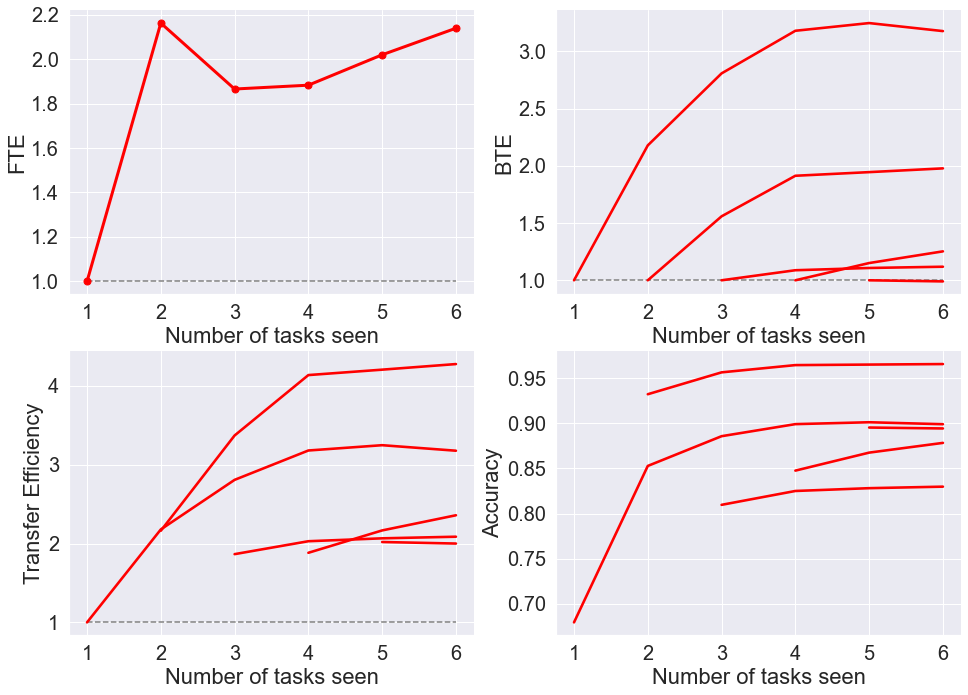

In [6]:
from spoken_digit_functions import calculate_results, plot_results

acc, bte, fte, te = calculate_results(accuracy_all_dnn)
plot_results(acc, bte, fte, te)

### Shuffled speaker
<br>

The default order of speakers is George followed by Jackson, Lucas, Nicolas, Theo, Yweweler. But we offer a variable `shuffle`. If we set `shuffle = True`, the order of speakers will be shuffled before each repetition starts.

By shuffling the speakers and averaging the results, we can see the intrinsic trend of Progressive Learning, i.e. the transfer efficiency increases monotonously with the 'noises' canceled out.

---
Here we use **L2F** for less computation cost, and set the number of repetitions large enough.

In [ ]:
from spoken_digit_functions import single_experiment,calculate_results, plot_results

model = 'dnn'
ntrees = 10     # number of trees, used when model is uf
shuffle = True
num_repetition = 400

accuracy_list = Parallel(n_jobs= 1)(delayed(single_experiment)(x, y, y_speaker, ntrees, model, shuffle) for _ in range(num_repetition))

accuracy_all_dnn_shuffle = np.average(accuracy_list, axis = 0)

# ICLR Paper figures

In [11]:
# load cache data
import numpy as np
from numpy import load

accuracy_all_dnn = np.load('0222_100rep_dnn.npy')
accuracy_all_uf  = np.load('0222_100rep_uf.npy')
accuracy_all_dnn_shuffle = np.load('0222_400rep_dnn_shuffle.npy')
accuracy_all_uf_shuffle = np.load('0222_400rep_uf_shuffle.npy')

In [12]:
from spoken_digit_functions import calculate_results, plot_results

acc_dnn, bte_dnn, fte_dnn, te_dnn = calculate_results(accuracy_all_dnn)
acc_uf, bte_uf, fte_uf, te_uf = calculate_results(accuracy_all_uf)

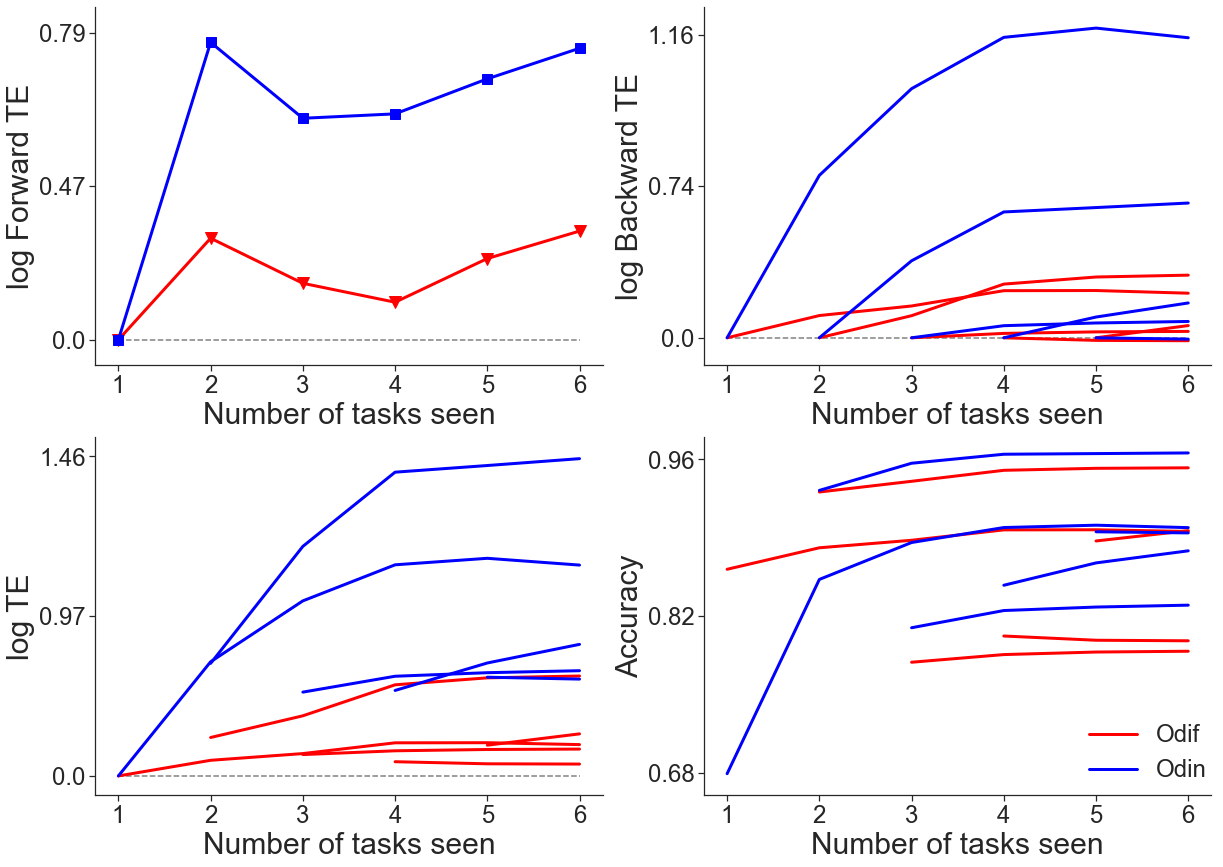

In [13]:
# L2F vs L2N, without shuffle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

num_tasks = 6
sns.set(style='ticks')

fontsize = 30
ticksize = 24
markersize = 12
linewidth = 3

#fig, ax = plt.subplots(2, 2, figsize=(16, 11.5))
fig, ax = plt.subplots(2, 2, figsize=(20, 14.5))

# FTE
ax[0][0].plot(np.arange(1, num_tasks + 1), fte_uf, c='red', marker='v', markersize=markersize, linewidth=linewidth, label = 'L2F')
ax[0][0].plot(np.arange(1, num_tasks + 1), fte_dnn, c='blue', marker='s', markersize=markersize*0.8, linewidth=linewidth, label = 'L2N')
ax[0][0].hlines(1, 1, num_tasks, colors='grey', linestyles='dashed', linewidth=0.5*linewidth)
ax[0][0].tick_params(labelsize=ticksize)
ax[0][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][0].set_ylabel('log Forward TE',fontsize=fontsize)
#ax[0][0].yaxis.set_major_locator(MultipleLocator(0.4))
ax[0][0].set_yticks([1, 1.6, 2.2])
ax[0][0].set_ylim(0.9, 2.3)

log_lbl = np.round(
    np.log([1, 1.6, 2.2]),
    2
)
labels = [item.get_text() for item in ax[0][0].get_yticklabels()]

for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])

ax[0][0].set_yticklabels(labels)

right_side = ax[0][0].spines["right"]
right_side.set_visible(False)
top_side = ax[0][0].spines["top"]
top_side.set_visible(False)

# BTE
for i in range(num_tasks):
    et = np.asarray(bte_uf[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[0][1].plot(ns, et, c='red', linewidth=linewidth)
for i in range(num_tasks):
    et = np.asarray(bte_dnn[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[0][1].plot(ns, et, c='blue', linewidth=linewidth)
ax[0][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][1].set_ylabel('log Backward TE', fontsize=fontsize)
ax[0][1].tick_params(labelsize=ticksize)
ax[0][1].hlines(1, 1, num_tasks, colors='grey', linestyles='dashed', linewidth=0.5*linewidth)
#ax[0][1].yaxis.set_major_locator(MultipleLocator(0.3))

ax[0][1].set_yticks([1, 2.1, 3.2])
ax[0][1].set_ylim(0.8, 3.4)

log_lbl = np.round(
    np.log([1, 2.1, 3.2]),
    2
)
labels = [item.get_text() for item in ax[0][1].get_yticklabels()]

for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])

ax[0][1].set_yticklabels(labels)

right_side = ax[0][1].spines["right"]
right_side.set_visible(False)
top_side = ax[0][1].spines["top"]
top_side.set_visible(False)

# TE
for i in range(num_tasks):
    et = np.asarray(te_uf[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[1][0].plot(ns, et, c='red', linewidth=linewidth)
for i in range(num_tasks):
    et = np.asarray(te_dnn[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[1][0].plot(ns, et, c='blue', linewidth=linewidth)
ax[1][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][0].set_ylabel('log TE', fontsize=fontsize)
ax[1][0].tick_params(labelsize=ticksize)
ax[1][0].hlines(1, 1, num_tasks, colors='grey', linestyles='dashed', linewidth=0.5*linewidth)
ax[1][0].yaxis.set_major_locator(MultipleLocator(1))

ax[1][0].set_yticks([1, 2.65,4.3])
ax[1][0].set_ylim(0.8, 4.5)

log_lbl = np.round(
    np.log([1, 2.65,4.3]),
    2
)
labels = [item.get_text() for item in ax[1][0].get_yticklabels()]

for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])

ax[1][0].set_yticklabels(labels)

right_side = ax[1][0].spines["right"]
right_side.set_visible(False)
top_side = ax[1][0].spines["top"]
top_side.set_visible(False)

# Accuracy
for i in range(num_tasks):
    et = 1 - np.asarray(acc_uf[i])
    ns = np.arange(i + 1, num_tasks + 1)
    if i == 0: ax[1][1].plot(ns, et, c='red', linewidth=linewidth, label = 'Odif')
    else: ax[1][1].plot(ns, et, c='red', linewidth=linewidth)
for i in range(num_tasks):
    et = 1 - np.asarray(acc_dnn[i])
    ns = np.arange(i + 1, num_tasks + 1)
    if i==0: ax[1][1].plot(ns, et, c='blue', linewidth=linewidth, label = 'Odin')
    else: ax[1][1].plot(ns, et, c='blue',linewidth=linewidth)
ax[1][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][1].set_ylabel('Accuracy', fontsize=fontsize)
ax[1][1].tick_params(labelsize=ticksize)
ax[1][1].yaxis.set_major_locator(MultipleLocator(0.08))
ax[1][1].set_yticks([0.68, 0.82, 0.96])
ax[1][1].set_ylim(0.66, 0.98)

right_side = ax[1][1].spines["right"]
right_side.set_visible(False)
top_side = ax[1][1].spines["top"]
top_side.set_visible(False)

ax[1][1].legend(loc=(0.74,0.01),fontsize = fontsize*0.8,edgecolor = "1")# legend

plt.savefig('language_odif_odin.pdf')

In [14]:
acc_dnn, bte_dnn, fte_dnn, te_dnn = calculate_results(accuracy_all_dnn_shuffle)
acc_uf, bte_uf, fte_uf, te_uf = calculate_results(accuracy_all_uf_shuffle)

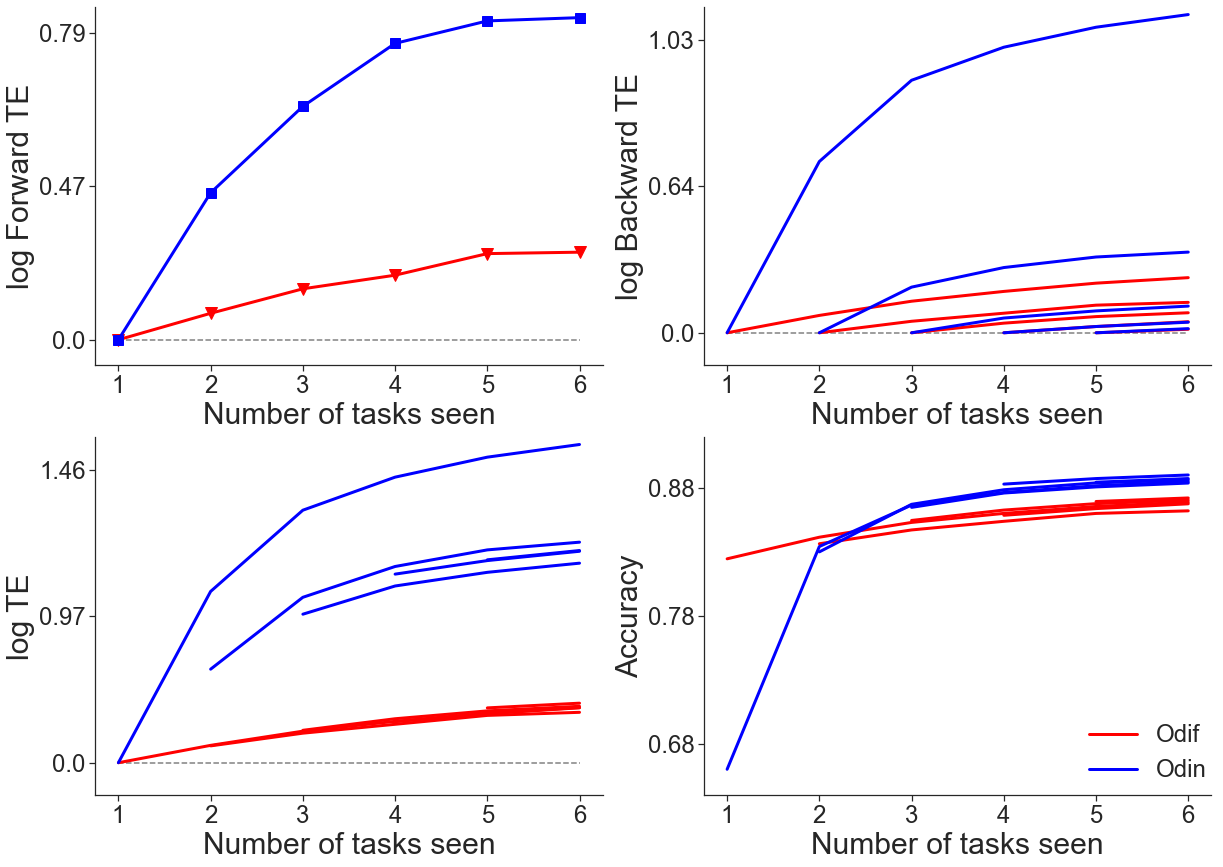

In [15]:
# L2F vs L2N, without shuffle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

num_tasks = 6
sns.set(style='ticks')

fontsize = 30
ticksize = 24
markersize = 12
linewidth = 3

#fig, ax = plt.subplots(2, 2, figsize=(16, 11.5))
fig, ax = plt.subplots(2, 2, figsize=(20, 14.5))

# FTE
ax[0][0].plot(np.arange(1, num_tasks + 1), fte_uf, c='red', marker='v', markersize=markersize, linewidth=linewidth, label = 'Odif')
ax[0][0].plot(np.arange(1, num_tasks + 1), fte_dnn, c='blue', marker='s', markersize=markersize*0.8, linewidth=linewidth, label = 'Odin')
ax[0][0].hlines(1, 1, num_tasks, colors='grey', linestyles='dashed', linewidth=0.5*linewidth)
ax[0][0].tick_params(labelsize=ticksize)
ax[0][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][0].set_ylabel('log Forward TE',fontsize=fontsize)
#ax[0][0].yaxis.set_major_locator(MultipleLocator(0.4))
ax[0][0].set_yticks([1, 1.6, 2.2])
ax[0][0].set_ylim(0.9, 2.3)

log_lbl = np.round(
    np.log([1, 1.6, 2.2]),
    2
)
labels = [item.get_text() for item in ax[0][0].get_yticklabels()]

for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])

ax[0][0].set_yticklabels(labels)

right_side = ax[0][0].spines["right"]
right_side.set_visible(False)
top_side = ax[0][0].spines["top"]
top_side.set_visible(False)

# BTE
for i in range(num_tasks):
    et = np.asarray(bte_uf[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[0][1].plot(ns, et, c='red', linewidth=linewidth)
for i in range(num_tasks):
    et = np.asarray(bte_dnn[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[0][1].plot(ns, et, c='blue', linewidth=linewidth)
ax[0][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][1].set_ylabel('log Backward TE', fontsize=fontsize)
ax[0][1].tick_params(labelsize=ticksize)
ax[0][1].hlines(1, 1, num_tasks, colors='grey', linestyles='dashed', linewidth=0.5*linewidth)
#ax[0][1].yaxis.set_major_locator(MultipleLocator(0.3))

ax[0][1].set_yticks([1, 1.9, 2.8])
ax[0][1].set_ylim(0.8, 3)

log_lbl = np.round(
    np.log([1, 1.9, 2.8]),
    2
)
labels = [item.get_text() for item in ax[0][1].get_yticklabels()]

for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])

ax[0][1].set_yticklabels(labels)

right_side = ax[0][1].spines["right"]
right_side.set_visible(False)
top_side = ax[0][1].spines["top"]
top_side.set_visible(False)

# TE
for i in range(num_tasks):
    et = np.asarray(te_uf[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[1][0].plot(ns, et, c='red', linewidth=linewidth)
for i in range(num_tasks):
    et = np.asarray(te_dnn[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[1][0].plot(ns, et, c='blue', linewidth=linewidth)
ax[1][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][0].set_ylabel('log TE', fontsize=fontsize)
ax[1][0].tick_params(labelsize=ticksize)
ax[1][0].hlines(1, 1, num_tasks, colors='grey', linestyles='dashed', linewidth=0.5*linewidth)
ax[1][0].yaxis.set_major_locator(MultipleLocator(1))

ax[1][0].set_yticks([1, 1.9, 2.8])
ax[1][0].set_ylim(0.8, 3)

log_lbl = np.round(
    np.log([1, 2.65,4.3]),
    2
)
labels = [item.get_text() for item in ax[1][0].get_yticklabels()]

for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])

ax[1][0].set_yticklabels(labels)

right_side = ax[1][0].spines["right"]
right_side.set_visible(False)
top_side = ax[1][0].spines["top"]
top_side.set_visible(False)

# Accuracy
for i in range(num_tasks):
    et = 1 - np.asarray(acc_uf[i])
    ns = np.arange(i + 1, num_tasks + 1)
    if i == 0: ax[1][1].plot(ns, et, c='red', linewidth=linewidth, label = 'Odif')
    else: ax[1][1].plot(ns, et, c='red', linewidth=linewidth)
for i in range(num_tasks):
    et = 1 - np.asarray(acc_dnn[i])
    ns = np.arange(i + 1, num_tasks + 1)
    if i==0: ax[1][1].plot(ns, et, c='blue', linewidth=linewidth, label = 'Odin')
    else: ax[1][1].plot(ns, et, c='blue',linewidth=linewidth)
ax[1][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][1].set_ylabel('Accuracy', fontsize=fontsize)
ax[1][1].tick_params(labelsize=ticksize)
ax[1][1].yaxis.set_major_locator(MultipleLocator(0.08))
ax[1][1].set_yticks([0.68, 0.78, 0.88])
ax[1][1].set_ylim(0.64, 0.92)

right_side = ax[1][1].spines["right"]
right_side.set_visible(False)
top_side = ax[1][1].spines["top"]
top_side.set_visible(False)

ax[1][1].legend(loc=(0.74,0.01),fontsize = fontsize*0.8,edgecolor = "1")# legend

plt.savefig('language_odif_odin_shuffle.pdf')

# Main paper figure

In [32]:
# load cache data
import numpy as np
from numpy import load

accuracy_all_dnn = np.load('0222_100rep_dnn.npy')
accuracy_all_uf  = np.load('0222_100rep_uf.npy')
accuracy_all_dnn_shuffle = np.load('0222_400rep_dnn_shuffle.npy')
accuracy_all_uf_shuffle = np.load('0222_400rep_uf_shuffle.npy')

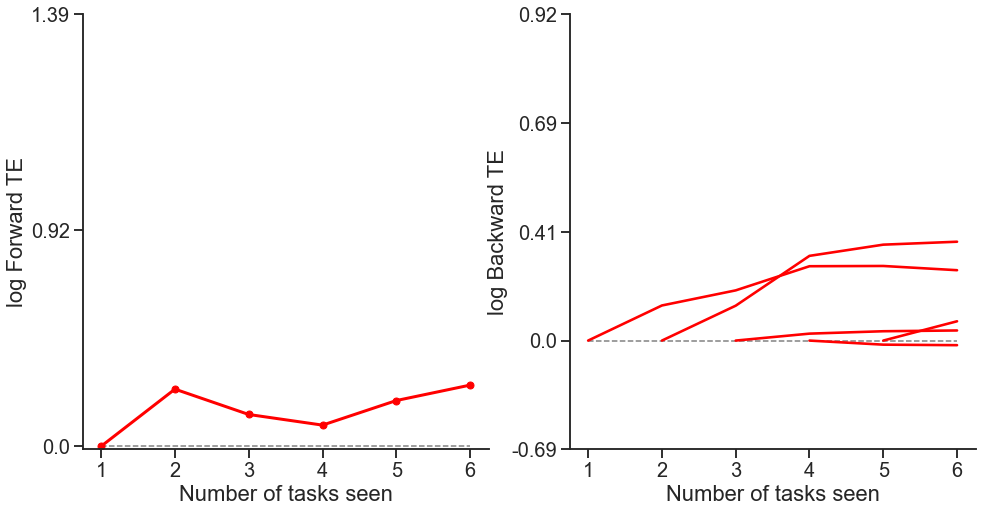

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from spoken_digit_functions import calculate_results, plot_results

acc, bte, fte, te = calculate_results(accuracy_all_uf)

sns.set_context("talk")
num_tasks = 6

clr = ["#e41a1c", "#a65628", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#CCCC00"]
fontsize = 22
ticksize = 20

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(np.arange(1, num_tasks + 1), fte, c='red', marker='.', markersize=14, linewidth=3)
ax[0].hlines(1, 1, num_tasks, colors='grey', linestyles='dashed', linewidth=1.5)
ax[0].tick_params(labelsize=ticksize)
ax[0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0].set_ylabel('log Forward TE', fontsize=fontsize)
ax[0].set_yticks([1, 2.5, 4])

log_lbl = np.round(
    np.log([1,2.5,4]),
    2
)
labels = [item.get_text() for item in ax[0].get_yticklabels()]

for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])

ax[0].set_yticklabels(labels)

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)

for i in range(num_tasks):
    et = np.asarray(bte[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[1].plot(ns, et, c='red', linewidth=2.6)

ax[1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1].set_ylabel('log Backward TE', fontsize=fontsize)
ax[1].tick_params(labelsize=ticksize)
ax[1].hlines(1, 1, num_tasks, colors='grey', linestyles='dashed', linewidth=1.5)
ax[1].set_yticks([.5, 1, 1.5, 2, 2.5])

log_lbl = np.round(
    np.log([.5, 1, 1.5, 2, 2.5]),
    2
)
labels = [item.get_text() for item in ax[1].get_yticklabels()]

for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])

ax[1].set_yticklabels(labels)

right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)

plt.savefig('language.pdf')